# Kantar

- Quentin Fisch
- Bastien Pouessel
- Theo Ripoll
- Tom Genlis
- Arnaud Baradat


## Introduction

Kantar nous a fourni un jeu de données contenant des informations sur les habitudes de 5000 consommateurs.
L'objectif de notre démarche est de grouper ces consommateurs en différents clusters afin de mieux comprendre leurs habitudes et de pouvoir leur proposer des offres plus adaptées.
Pour ce faire nous allons constituer notre anaylse en 3 étapes :
- Clusterisation des consommateurs en fonction de deux groupes de variables (usages et attitudes)
- Détermination du nombre de variables à retenir pour chaque groupe & analyse des clusters
- Détermination d'algorithme de machine learning pour prédire le cluster d'un nouveau consommateur en fonction d'un set de variables (usages en fonctions des attitudes et inversement)

Les différents algoritmes de clustering que nous avons essayé ne sont pas présentés dans un ordre particulier de part le fait que nous en avons essayé nombre en parallèle. Nous avons choisi de présenter les résultats des algorithmes qui nous ont semblé les plus pertinents.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import Birch, KMeans, AgglomerativeClustering, DBSCAN

from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from xgboost import plot_importance

from xgboost import XGBClassifier
import matplotlib.ticker as mtick

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
from sklearn import set_config
set_config(transform_output = "pandas")

### Chargement de la donnée

In [3]:
DATA_PATH = "data/"
data = pd.read_csv(DATA_PATH + 'label_encoded.csv', sep=';')
data.head()

cle    Respondent_ID    weight  A11  A12  A13  A14  A4   A5  A5bis  ...  \
0    1  MET20_999999996  2.501255    1    0    0    0   1  2.0    NaN  ...   
1    2   MET20_98888888  0.722914    1    0    0    0   1  5.0    NaN  ...   
2    3    MET20_1978307  1.039611    1    0    0    0   1  2.0    NaN  ...   
3    4    MET20_1302078  0.976590    1    1    1    0   1  1.0    NaN  ...   
4    5    MET20_1869308  0.812315    0    1    0    0   2  NaN    1.0  ...   

   RS193  RS102RECAP  rs11recap2  RS11recap  RS193bis  RS2Recap  RS56Recap  \
0      2           4           1          2       NaN         1          1   
1      2           1           1          2       NaN         4          1   
2      2           3           2          1       NaN         3          2   
3      2           2           1          2       NaN         5          3   
4      2           3           2          1       NaN         3          1   

   RS2  RS11  RS102  
0   24     0      4  
1   50     0      1  
2   37     1      3  
3   63     0      2  
4   44     1      3  

[5 rows x 133 columns]

Les données sont composées de 5000 lignes et 133 colonnes. Elles sont composées de variables catégorielles, numériques et booléennes.

Les features sont divisées en 3 catégories :
- Les features qui décrivent les usages des personnes
- Celles qui décrivent leurs attitudes 
- Les informations socio-démographiques

Groupons nos données en fonction des 3 sets de variables pour notre analyse.

In [4]:
to_drop = ["Respondent_ID", "weight"]

usages = to_drop + ["A11", "A12", "A13", "A14", "A4", "A5", "A5bis", "A8_1_slice", "A8_2_slice", "A8_3_slice", "A8_4_slice", "B1_1_slice", "B1_2_slice", "B2_1_slice", "B2_2_slice", "B3", "B4", "B6", "C1_1_slice", "C1_2_slice", "C1_3_slice", "C1_4_slice", "C1_5_slice", "C1_6_slice", "C1_7_slice", "C1_8_slice", "C1_9_slice"]

attitudes = to_drop + ["A9_1_slice", "A9_2_slice", "A9_3_slice", "A9_4_slice", "A9_5_slice", "A9_6_slice", "A9_7_slice", "A9_8_slice", "A9_9_slice", "A9_10_slice", "A9_11_slice", "A9_12_slice", "A9_13_slice", "A9_14_slice", "A9_15_slice", "A9_16_slice", "A10_1_slice", "A10_2_slice", "A10_3_slice", "A10_4_slice", "A10_5_slice", "A10_6_slice", "A10_7_slice", "A10_8_slice", "A11_1_slice", "A11_2_slice", "A11_3_slice", "A11_4_slice", "A11_5_slice", "A11_6_slice", "A11_7_slice", "A11_8_slice", "A11_9_slice", "A11_10_slice", "A11_11_slice", "A11_12_slice", "A11_13_slice"]

socio_demographical = ["rs3", "rs5", "rs6", "RS1", "RS191", "RS192", "RS193", "RS102RECAP", "rs11recap2", "RS11recap", "RS193bis", "RS2Recap", "RS56Recap", "RS2", "RS11", "RS102"]

data_usages = data[usages].copy()
data_attitudes = data[attitudes].copy()
data_socio_demographical = data[socio_demographical].copy()

Il y a une variable `weight` qui est un poids d'importance pour chaque individu. Nous allons l'utiliser pour pondérer le poids des individus dans nos analyses. \
De même, il y a une variable `Respondent_ID` qui est l'identifiant unique de chaque individu. Nous allons l'ignorer pour nos analyses. 

In [5]:
respondents_usages = data_usages["Respondent_ID"]
weights_usages = data_usages["weight"]
data_usages = data_usages.drop(to_drop, axis=1)

respondents_attitudes = data_attitudes["Respondent_ID"]
weights_attitudes = data_attitudes["weight"]
data_attitudes = data_attitudes.drop(to_drop, axis=1)

In [6]:
def preprocess_data(input_data, columns, to_drop):
    data = input_data[columns].copy()
    respondents = data["Respondent_ID"]
    weights = data["weight"]
    data = data.drop(to_drop, axis=1) 

    ohe = OneHotEncoder(sparse_output=False)
    data_enc = ohe.fit_transform(data)
    data_weighted = data_enc.multiply(weights, axis="index")
    
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_weighted)
    return data_scaled, respondents

In [7]:
data_attitude_processed, respondents_attitude = preprocess_data(data, attitudes, to_drop)
data_usage_processed, respondents_usage = preprocess_data(data, usages, to_drop)
data_usage_socio_processed, respondents_usage_socio = preprocess_data(data, usages + socio_demographical, to_drop)
data_attitude_socio_processed, respondents_attitude_socio = preprocess_data(data, attitudes + socio_demographical, to_drop)

Pour nous permettre de visualiser les données, nous allons réduire la dimension des données en utilisant une méthode de réduction de dimension. Nous allons utiliser l'ACP pour cela. Voulant garder un maximum d'information, nous allons garder réduire en dimension 3 et afficher notre donnée en 3D.

In [8]:
def apply_pca(data, n_components=3):
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)
    return data_pca, pca

In [ ]:
def get_clusters_repartition(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

In [9]:
data_attitude_pca, pca_attitude = apply_pca(data_attitude_processed)
data_usage_pca, pca_usage = apply_pca(data_usage_processed)

In [10]:
def plot_3D(data, labels=None):
    import plotly.graph_objects as go

    fig = go.Figure(data=[go.Scatter3d(
        x=data.iloc[:,0],
        y=data.iloc[:,1],
        z=data.iloc[:,2],
        mode='markers',
        marker=dict(
            size=4,
            color=labels,
            colorscale='Viridis',
            opacity=0.8
        )
    )])

    fig.update_layout(
        scene = dict(
            xaxis_title='PC1',
            yaxis_title='PC2',
            zaxis_title='PC3'
        ),
        margin=dict(l=0, r=0, b=0, t=0)
    )
    fig.show()

Pour évaluer la qualité de nos clusters au delà de l'aspect visuel, nous allons utiliser le silhouette score.

La métrique du silhouette score est utilisée pour évaluer la qualité d'une clusterisation dans un espace de données. Elle mesure à quel point chaque point d'un cluster est proche des points des autres clusters. Cette métrique varie de -1 à 1, où une valeur élevée indique que les points sont bien regroupés et bien séparés des autres clusters.

In [11]:
def compute_silhouette_score(data, labels):
    silhouette =  silhouette_score(data, labels)
    print(f'Silhouette Coefficient: {silhouette}')

# 1 - Clusterisation des consommateurs en fonction de deux groupes de variables (usages et attitudes)

## 1.1 - Attitudes des consommateurs

Commencons par clusteriser les consommateurs en fonction de leurs attitudes.

In [12]:
plot_3D(data_attitude_pca)

### BIRCH

L'algorithme BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies) est une méthode de clustering efficace pour de très grands ensembles de données, qui construit progressivement une structure d'arbre appelée CF Tree (Clustering Feature Tree) pour condenser les données, permettant ainsi d'effectuer le clustering rapidement en utilisant un espace mémoire limité, tout en étant particulièrement adapté aux données multidimensionnelles.

In [13]:
brc = Birch(branching_factor=100, threshold=.5, n_clusters=6)
brc.fit(data_attitude_pca)
labels_birch = brc.predict(data_attitude_pca)

In [14]:
plot_3D(data_attitude_pca, labels_birch)

In [15]:
compute_silhouette_score(data_attitude_pca, labels_birch)

Silhouette Coefficient: 0.21333151538709663


In [20]:
get_clusters_repartition(labels_birch)

{0: 707, 1: 3096, 2: 39, 3: 125, 4: 15, 5: 1018}

### Elbow method

Une intuition était de faire la méthode du coude pour trouver un nombre de clusters optimal. Nous avons choisi la métrique de silhouette score en combinaison avec BIRCH.

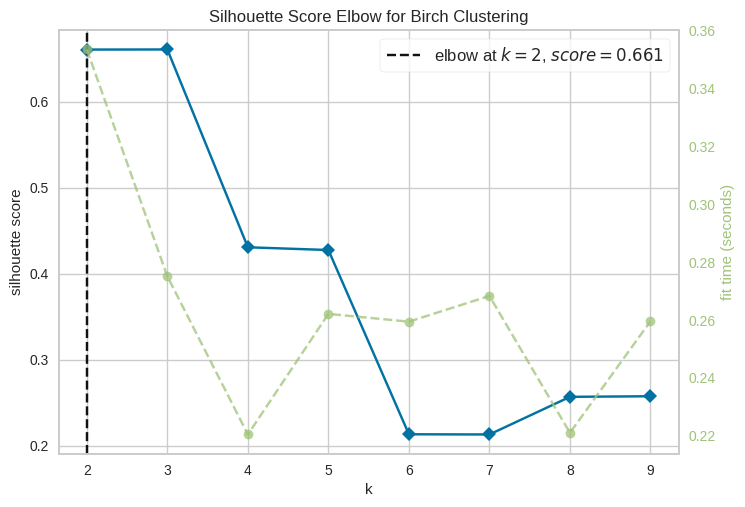

<Axes: title={'center': 'Silhouette Score Elbow for Birch Clustering'}, xlabel='k', ylabel='silhouette score'>

In [16]:
model = Birch(branching_factor=100, threshold=.5, n_clusters=None)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings= True)
visualizer.fit(data_attitude_pca)
visualizer.show()

La méthode nous indique que le nombre de clusters optimal est 3. Cependant les scores de silouette sont très faibles, ce qui indique que les clusters ne sont pas bien séparés. De plus, il semble logique de pouvoir faire une distinction plus fine des différents modes de consommation.

Nous avons donc essayé d'autres méthodes de clustering avec pour objectif de trouver des algorithmes fonctionnels pour une nombre de clusters entre 5 et 7.

#### DBSCAN

L'algorithme DBSCAN (Density-Based Spatial Clustering of Applications with Noise) est une méthode de clustering basée sur la densité qui identifie des clusters comme des zones de haute densité séparées par des zones de faible densité, capable de trouver des clusters de formes arbitraires et de gérer le bruit dans les données.

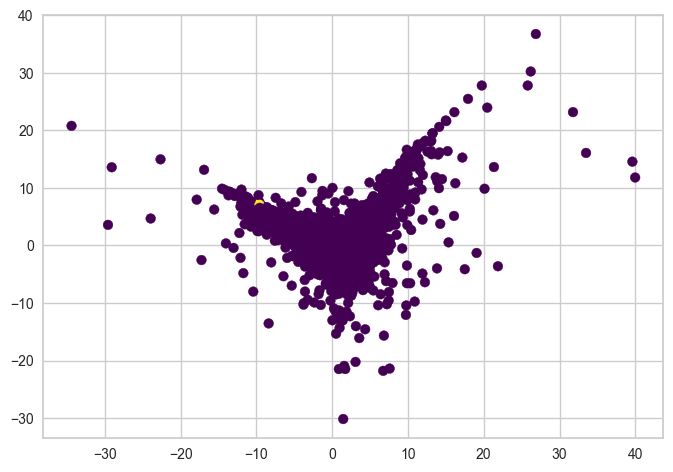

In [21]:
dbscan = DBSCAN()
dbscan.fit(data_attitude_processed)
labels_dbscan = dbscan.labels_

plt.scatter(data_attitude_pca.iloc[:,0], data_attitude_pca.iloc[:,1], c=labels_dbscan, cmap='viridis')
plt.show()

In [22]:
compute_silhouette_score(data_attitude_pca, labels_dbscan)

Silhouette Coefficient: -0.3361961777247354


In [23]:
get_clusters_repartition(labels_dbscan)

{-1: 4979, 0: 5, 1: 5, 2: 6, 3: 5}

DBSCAN ne marche pas du tout pour notre jeu de données. Il ne trouve quasiment qu'un seul cluster et son score de silouette est de -0.3.

### Agglomerative Clustering

L'algorithme de clustering agglomératif est une méthode de clustering hiérarchique qui fusionne progressivement les paires de clusters les plus proches en un seul cluster, jusqu'à ce que tous les points de données soient regroupés en un nombre spécifié de clusters ou en un seul cluster global.

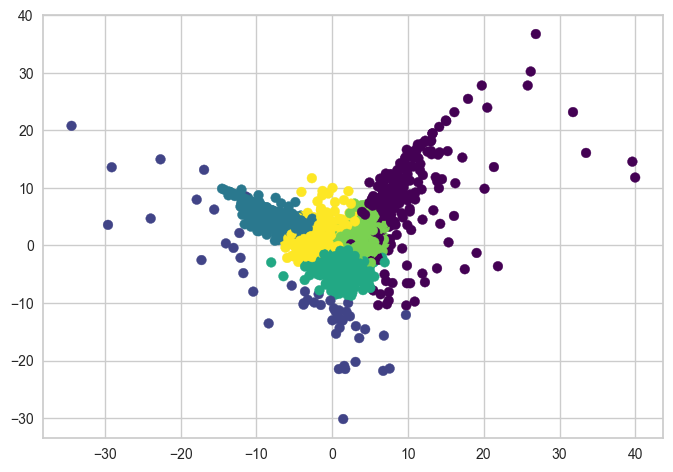

In [24]:
agglo = AgglomerativeClustering(n_clusters=6)
agglo.fit(data_attitude_pca)
labels_agglo = agglo.labels_

plt.scatter(data_attitude_pca.iloc[:,0], data_attitude_pca.iloc[:,1], c=labels_agglo, cmap='viridis')
plt.show()

In [25]:
plot_3D(data_attitude_pca, labels_agglo)

In [26]:
compute_silhouette_score(data_attitude_pca, labels_agglo)

Silhouette Coefficient: 0.2769967694096261


In [27]:
get_clusters_repartition(labels_agglo)

{0: 252, 1: 52, 2: 657, 3: 1845, 4: 936, 5: 1258}

Bien que les résultats soient meilleurs que ceux de DBSCAN, les clusters ne sont pas mieux séparés qu'avec BIRCH et le score de silouette est similaire.

### KMeans


L'algorithme K-Means est une méthode de clustering partitionnelle qui divise un ensemble de données en `k` clusters distincts en minimisant la variance intra-cluster, assignant chaque point au cluster avec le centre (ou centroïde) le plus proche.

In [28]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(data_attitude_pca)
labels_kmeans_attitude = kmeans.labels_

In [29]:
plot_3D(data_attitude_pca, labels_kmeans_attitude)

In [30]:
compute_silhouette_score(data_attitude_pca, labels_kmeans_attitude)

Silhouette Coefficient: 0.338041861961927


In [31]:
get_clusters_repartition(labels_kmeans_attitude)

{0: 1329, 1: 115, 2: 2189, 3: 513, 4: 58, 5: 796}

Le score de silhouette est meilleur que les autres algorithmes, mais reste faible. Les clusters formés par KMeans semblent les plus qualitatifs de tous les algorihmes.

### Conclusion

Nous avons choisi de retenir l'algorithme KMeans pour la clusterisation des attitudes des consommateurs. Nous avons choisi de retenir 6 clusters pour notre analyse. Les clusters formés par KMeans semblent les plus qualitatifs de tous les algorihmes.

## 1.2 - Usages des consommateurs

Faisons la même démarche pour les usages des consommateurs.

In [32]:
plot_3D(data_usage_pca)

### BIRCH

In [65]:
brc = Birch(branching_factor=100, threshold=.5, n_clusters=6)
brc.fit(data_usage_pca)
labels_birch = brc.predict(data_usage_pca)

In [66]:
plot_3D(data_usage_pca, labels_birch)

In [67]:
compute_silhouette_score(data_usage_pca, labels_birch)

Silhouette Coefficient: 0.24985154318162914


In [68]:
get_clusters_repartition(labels_birch)

{0: 3147, 1: 123, 2: 38, 3: 1678, 4: 3, 5: 11}

La qualité des clusters formés par BIRCH est très faible. Les scores de silhouette sont très faibles et les clusters ne sont pas bien séparés. Le comportement de BIRCH entre les usages et les attitudes est similaire.

### Elbow method

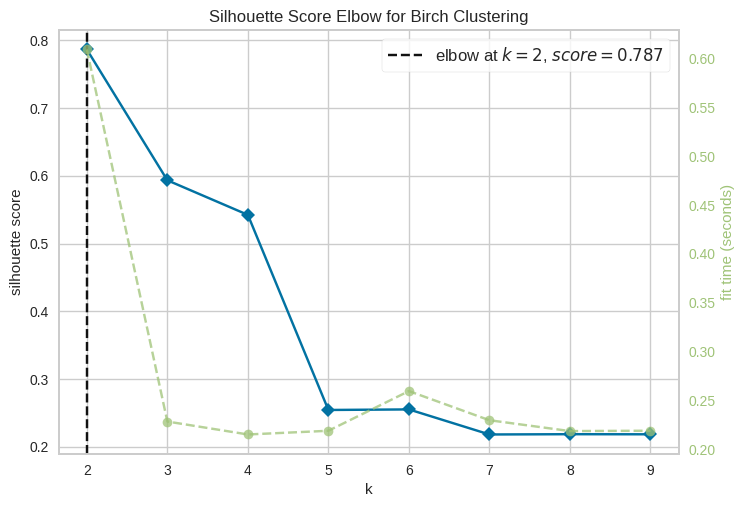

<Axes: title={'center': 'Silhouette Score Elbow for Birch Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
model = Birch(branching_factor=100, threshold=.5, n_clusters=None)
visualizer = KElbowVisualizer(model, k=(2,10),metric='silhouette', timings= True)
visualizer.fit(data_usage_pca)
visualizer.show()

La similarité de la qualité des clusters formés par BIRCH pour les attitudes et les usages se confirme avec des résultats avec la méthode du coude similaires.

### DBSCAN

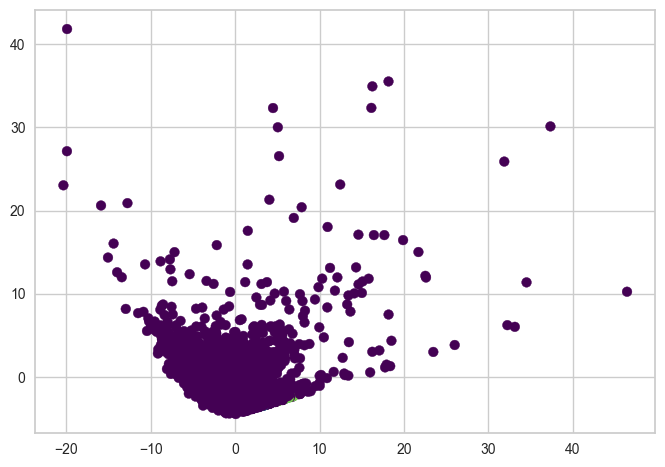

In [69]:
dbscan = DBSCAN()
dbscan.fit(data_usage_processed)
labels_dbscan = dbscan.labels_

plt.scatter(data_usage_pca.iloc[:,0], data_usage_pca.iloc[:,1], c=labels_dbscan, cmap='viridis')
plt.show()

In [70]:
compute_silhouette_score(data_usage_pca, labels_dbscan)

Silhouette Coefficient: -0.2320608689280465


In [71]:
get_clusters_repartition(labels_dbscan)

{-1: 4961, 0: 5, 1: 7, 2: 5, 3: 17, 4: 5}

Ici encore, DBSCAN ne marche pas du tout pour notre jeu de données. Quoique meilleur que sur les attitudes (5% de plus), il ne trouve quasiment qu'un seul cluster et son score de silouette est de -0.2.

### Agglomerative Clustering

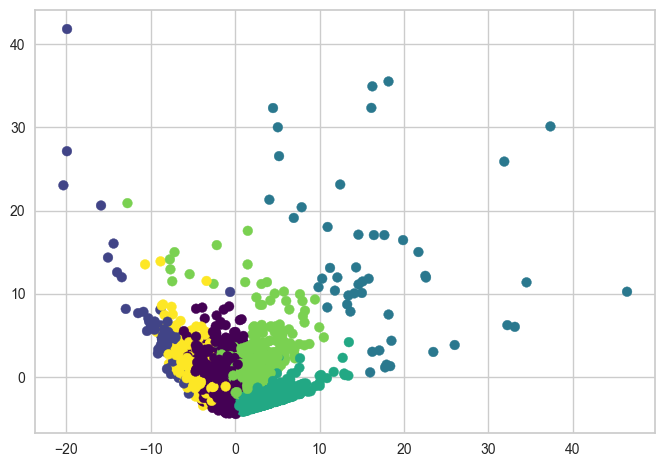

In [72]:
agglo = AgglomerativeClustering(n_clusters=6)
agglo.fit(data_usage_pca)
labels_agglo = agglo.labels_

plt.scatter(data_usage_pca.iloc[:,0], data_usage_pca.iloc[:,1], c=labels_agglo, cmap='viridis')
plt.show()

In [73]:
plot_3D(data_usage_pca, labels_agglo)

In [74]:
compute_silhouette_score(data_usage_pca, labels_agglo)

Silhouette Coefficient: 0.2956234247995735


In [75]:
get_clusters_repartition(labels_agglo)

{0: 2095, 1: 72, 2: 49, 3: 848, 4: 1568, 5: 368}

La filtrage des clusters par Agglomerative Clustering donne de moins bons résultats sur les usages que sur les attitudes. Cependant, les clusters sont mieux séparés qu'avec BIRCH et le score de silouette est plus meilleur (1%).

### KMeans

In [76]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(data_usage_pca)
labels_kmeans_usage = kmeans.labels_

In [123]:
plot_3D(data_usage_pca, labels_kmeans_usage)

In [78]:
compute_silhouette_score(data_usage_pca, labels_kmeans_usage)

Silhouette Coefficient: 0.2690938289125469


In [79]:
get_clusters_repartition(labels_kmeans_usage)

{0: 284, 1: 1225, 2: 53, 3: 1753, 4: 13, 5: 1672}

KMeans lui aussi, peine à trouver des clusters de qualité sur les usages. Cependant, à l'inverse des attitudes ce n'est pas le meilleur performeur qualitativement car agglomerative filtering donne des résultats bien plus cohérents visuellement. 

### Conclusion

Nous avons choisi de retenir l'algorithme Agglomerative filtering pour la clusterisation des usages des consommateurs. Nous avons choisi de retenir 6 clusters pour notre analyse. Les clusters formés par Agglomerative filtering semblent les plus qualitatifs de tous les algorihmes. \
De plus, il semble plus dur de trouver des clusters de qualité sur les usages que sur les attitudes.

# 2 - Détermination du nombre de variables à retenir pour chaque groupe

Notre objectif est de déterminer le nombre de variables à retenir pour chaque groupe. \
Pour ce faire, nous allons entrainer un modèle XGBoost pour chaque groupe de variables et regarder la performance de chaque modèle en fonction du nombre de variables. 
XBoost est un algorithme de machine learning qui est très performant pour les problèmes de classification et de régression. Ce choix a été en partie motivé par le fait que la bibliothèque XGBoost possède une fonctionnalité qui permet de visualiser l'importance des variables dans le modèle.

## 2.1 - Attitudes des consommateurs

Commencons par les attitudes des consommateurs.

Nous ferons une validation croisée pour chaque nombre de variables pour évaluer la performance de notre modèle. \
Après avoir confirmé que notre modèle est bien calibré, nous allons regarder l'importance des variables pour chaque modèle.

In [80]:
seed = 42

model = XGBClassifier(random_state=seed, enable_categorical=False)
scores = cross_val_score(model, data_attitude_processed, labels_kmeans_attitude, cv=5, n_jobs=-1)
scores

array([0.923, 0.915, 0.9  , 0.92 , 0.915])

In [81]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.02)


Notre modèle arrive à très bien prédire le cluster des consommateurs avec un score de 91% de précision.

Ré-entrainons notre modèle et regardons plus en details les performances de notre modèle.

In [82]:
X_train, X_test, y_train, y_test = train_test_split(data_attitude_processed, labels_kmeans_attitude, test_size=0.2, random_state=seed)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, predictions))

Accuracy: 92.00%
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       253
           1       1.00      0.75      0.86        28
           2       0.95      0.94      0.94       462
           3       0.97      0.86      0.92        88
           4       0.75      1.00      0.86        12
           5       0.90      0.92      0.91       157

    accuracy                           0.92      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.92      0.92      0.92      1000



Il semble que certaines classes soient beaucoup plus dures a prédire que d'autres (la classe 1 à une précision de 1 comparé à 0.75 pour la classe 4).

Cela est sûrement dû aux défauts de clusterisation de nos données. Nous avons choisi de retenir 6 clusters pour notre analyse, mais il est possible que 6 clusters ne soient pas le nombre optimal de clusters pour nos données. Ainsi ces petites variations de performance sont explicables et ne sont pas inquiétantes.

Regardons maintenant l'importance des variables pour notre modèle.

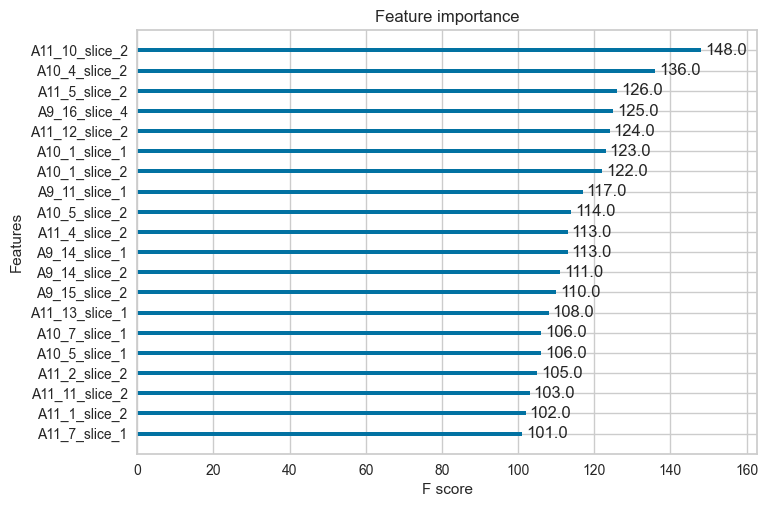

In [84]:
plot_importance(model, max_num_features=20, importance_type='weight');

Comme nous pouvons le voir, les 20 variables les plus importantes ont une importance relativement proportionnelle. Ceci montre une certaine homogénéité dans l'importance des variables. Cependant il se dégage une relation d'ordre dans l'importance des variables.

In [85]:
importance = model.get_booster().get_score(importance_type="weight")
# sort by value
sorted_importance = sorted(importance.items(), key=lambda kv: kv[1], reverse=True)
sorted_importance = np.array(sorted_importance)

In [86]:
question_importance = np.vectorize(lambda x: "_".join(x.split("_")[:-1]))(sorted_importance[:, 0])
question_importance, ind = np.unique(question_importance, return_index=True)
question_importance = question_importance[np.argsort(ind)]
question_importance

array(['A11_10_slice', 'A10_4_slice', 'A11_5_slice', 'A9_16_slice',
       'A11_12_slice', 'A10_1_slice', 'A9_11_slice', 'A10_5_slice',
       'A9_14_slice', 'A11_4_slice', 'A9_15_slice', 'A11_13_slice',
       'A10_7_slice', 'A11_2_slice', 'A11_11_slice', 'A11_1_slice',
       'A11_7_slice', 'A9_7_slice', 'A10_2_slice', 'A11_6_slice',
       'A9_9_slice', 'A11_8_slice', 'A9_6_slice', 'A9_3_slice',
       'A11_3_slice', 'A9_1_slice', 'A9_12_slice', 'A9_4_slice',
       'A9_2_slice', 'A9_10_slice', 'A9_13_slice', 'A11_9_slice',
       'A9_8_slice', 'A10_6_slice', 'A10_3_slice', 'A10_8_slice',
       'A9_5_slice'], dtype='<U12')

Les 3 variables les plus importantes pour le groupe des consommateurs dans leurs attitudes par rapport a leur jardin sont:
- `A11_10_slice`: Un moyen de réaliser jusqu’au bout quelque chose de vos propres mains
- `A10_4_slice`: Les espaces extérieurs permettent d’accéder à davantage d’activités de loisirs
- `A11_5_slice`: Un moyen de se resourcer, de refaire le plein d’énergie

Regardons maintenant la qualité de notre modèle en fonction du nombre de variables.

In [87]:
def benchmark_feature_importance(importance, data, labels):
    accuracies = []
    for i in range(1, len(importance)+1):
        features = importance[:i]
        X = data.loc[:, data.columns.str.startswith(tuple(features))]
        model = XGBClassifier(random_state=seed, enable_categorical=False)
        scores = cross_val_score(model, X, labels, cv=5, n_jobs=-1)
        accuracies.append(scores.mean() * 100)
    return accuracies

In [88]:
accuracies_by_feature_count = benchmark_feature_importance(question_importance, data_attitude_processed, labels_kmeans_attitude)

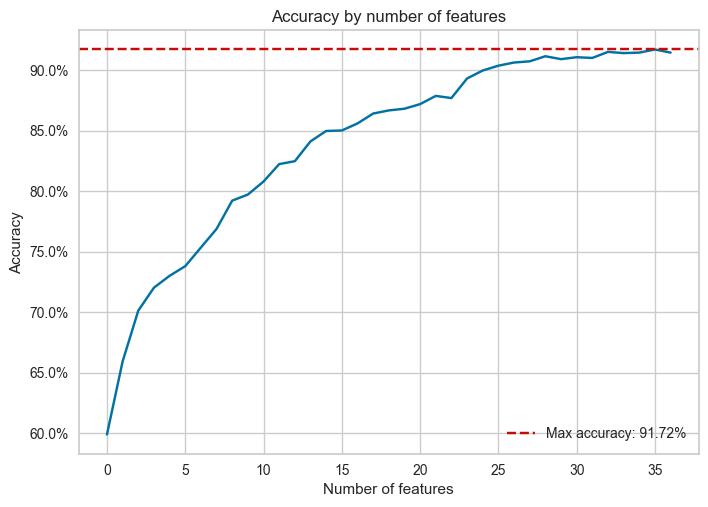

In [89]:
plt.plot(accuracies_by_feature_count)
max_accuracy = max(accuracies_by_feature_count)
plt.axhline(max_accuracy, color='r', linestyle='--', label=f"Max accuracy: {max_accuracy:.2f}%")
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Accuracy by number of features")
plt.legend()
plt.show()

Comme prévu la qualité de notre modèle augmente avec le nombre de variables.

Cette analyse nous montre que de notre questionnaire, nous pourrions réduire le nombre de questions à 10 (les 10 questions les plus importantes pour notre modèle) tout en gardant une 80% de précision.

Regardons ce que nous pouvons faire a partir des usages de consommateurs.

## 2.2 - Usages des consommateurs

In [94]:
model_usage = XGBClassifier(random_state=seed, enable_categorical=False)
scores_usage = cross_val_score(model_usage, data_usage_processed, labels_agglo, cv=5, n_jobs=-1)
scores_usage

array([0.931, 0.922, 0.903, 0.911, 0.91 ])

In [95]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_usage.mean(), scores_usage.std() * 2))

Accuracy: 0.92 (+/- 0.02)


Encore une fois, XGBoost arrive à très bien prédire le cluster des consommateurs avec un score de 92% de précision.

In [96]:
X_train, X_test, y_train, y_test = train_test_split(data_usage_processed, labels_agglo, test_size=0.2, random_state=seed)

model_usage.fit(X_train, y_train)

y_pred = model_usage.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, predictions))

Accuracy: 92.30%
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       407
           1       1.00      0.85      0.92        13
           2       1.00      0.86      0.92        14
           3       0.97      0.98      0.97       173
           4       0.93      0.92      0.92       322
           5       0.88      0.73      0.80        71

    accuracy                           0.92      1000
   macro avg       0.95      0.88      0.91      1000
weighted avg       0.92      0.92      0.92      1000



Il semble que les usages soient mieux représentés par notre modèle que les attitudes. Les classes sont mieux prédites et la précision est plus homogène. En effet la classe 1 a une précision de 1 et la classe 5 (la plus basse) a une précision de 0.88 (largement supérieur aux 0.75 de la plus basse précision de classe des attitudes).

Comme pour les attitudes, voyons l'importance des variables pour notre modèle.

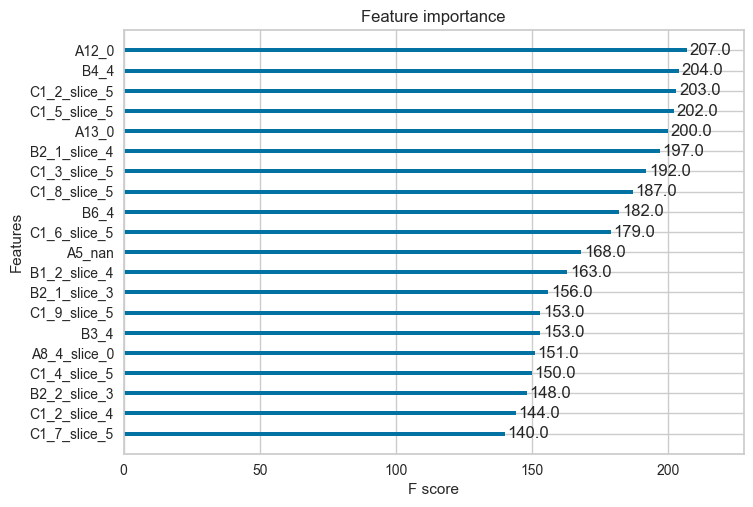

In [97]:
plot_importance(model_usage, max_num_features=20, importance_type='weight');

De part le fait qu'il y a moins de features pour les usages, les importances sont plus hautes, cependant la notion d´homonégénéité est toujours présente. Comme pour les attitudes il se dégage une relation d'ordre dans l'importance des variables.

In [98]:
importance_usage = model_usage.get_booster().get_score(importance_type="weight")
sorted_importance_usage = sorted(importance_usage.items(), key=lambda kv: kv[1], reverse=True)
sorted_importance_usage = np.array(sorted_importance_usage)

In [99]:
question_importance_usage = np.vectorize(lambda x: "_".join(x.split("_")[:-1]))(sorted_importance_usage[:, 0])
question_importance_usage, ind = np.unique(question_importance_usage, return_index=True)
question_importance_usage = question_importance_usage[np.argsort(ind)]
question_importance_usage

array(['A12', 'B4', 'C1_2_slice', 'C1_5_slice', 'A13', 'B2_1_slice',
       'C1_3_slice', 'C1_8_slice', 'B6', 'C1_6_slice', 'A5', 'B1_2_slice',
       'B3', 'C1_9_slice', 'A8_4_slice', 'C1_4_slice', 'B2_2_slice',
       'C1_7_slice', 'A11', 'A14', 'C1_1_slice', 'A4', 'B1_1_slice',
       'A8_1_slice', 'A8_2_slice', 'A8_3_slice', 'A5bis'], dtype='<U10')

Les 3 variables les plus importantes pour le groupe des consommateurs dans leurs usages de leur jardin sont:
- `A12`: Possession d’un balcon
- `B4`: Fréquence des récoltes du jardin
- `C1_2_slice`: Fréquence consultation sites dédiés au jardinage Des sites Internet d’enseignes de jardinerie

Regardons maintenant la qualité de notre modèle en fonction du nombre de variables.

In [100]:
accuracies_by_feature_count_usage = benchmark_feature_importance(question_importance_usage, data_usage_processed, labels_agglo)

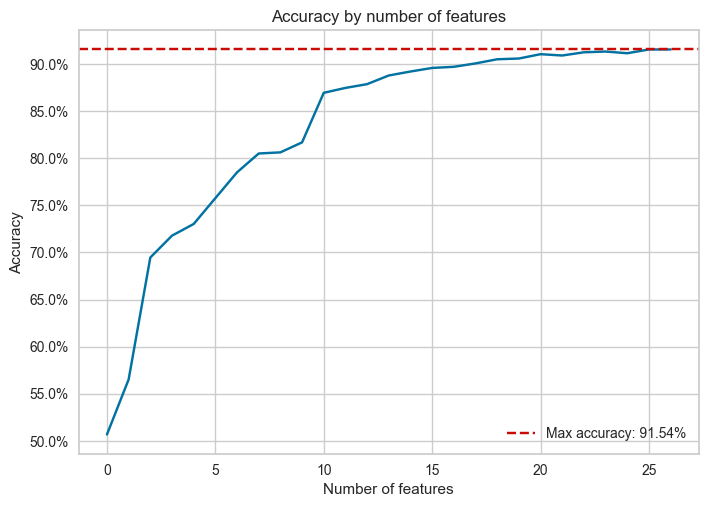

In [101]:
plt.plot(accuracies_by_feature_count_usage)
max_accuracy = max(accuracies_by_feature_count_usage)
plt.axhline(max_accuracy, color='r', linestyle='--', label=f"Max accuracy: {max_accuracy:.2f}%")
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Accuracy by number of features")
plt.legend()
plt.show()

Comme pour les attitudes, la qualité de notre modèle augmente avec le nombre de variables. De plus, comme notre modèle est plus performant, nous pouvons réduire le nombre de questions à 5 (les 5 questions les plus importantes pour notre modèle) tout en gardant une précision de 75%.

# 3 - Détermination d'algorithme de machine learning pour prédire le cluster d'un nouveau consommateur en fonction d'un set de variables (usages en fonctions des attitudes et inversement)

Pour la darnière partie de notre analyse, nous allons tenter de faire une prédiction du cluster (pour les clusters d'un subset donné) d'un nouveau consommateur à partir des données de l'autre subset.

Si nous avons les informations des usages d'un consommateur, nous allons essayer de prédire le cluster de ses attitudes et vice versa.

Comme pour le début de la partie 2, nous allons entrainer un modèle XGBoost pour chaque groupe de variables tout en lui donnant les clusterisations de l'autre groupe de variables comme label. Se faisant, il va apprendre à prédire le cluster d'un groupe de variables en fonction des clusters de l'autre groupe de variables.

Commencons par calculer les clusters pour les attitudes et les usages.

In [90]:
# PCA - Attitudes
data_attitude_socio_pca, pca_attitude_socio = apply_pca(data_attitude_socio_processed, n_components=3)

# PCA - Usage
data_usage_socio_pca, pca_usage_socio = apply_pca(data_usage_socio_processed, n_components=3)

# Clustering - Attitudes
kmeans_attitudes = KMeans(n_clusters=6, random_state=0).fit(data_attitude_socio_pca)
labels_attitudes_socio = kmeans_attitudes.labels_

# Clustering - Usage
birch_usage = AgglomerativeClustering(n_clusters=6).fit(data_usage_socio_pca)
labels_usage_socio = birch_usage.labels_

Séparons nos données en deux groupes de variables. Des données de test et d'entrainement.

In [91]:
RANDOM_STATE = 42
TEST_SIZE = 0.4

usage_train, usage_test, labels_usage_train, labels_usage_test = train_test_split(data_usage_socio_processed, labels_usage_socio, test_size=TEST_SIZE, random_state=RANDOM_STATE)
attitudes_train, attitudes_test, labels_attitude_train, labels_attitude_test = train_test_split(data_attitude_socio_processed, labels_attitudes_socio, test_size=TEST_SIZE, random_state=RANDOM_STATE)

Ayant toutes les pièces nécéssaires pour entrainer notre modèle, nous allons maintenant entrainer notre modèle et regarder sa performance.

### Estimation du cluster dans les attitudes, en fonction des usages d'un consommateur

Accuracy: 0.513


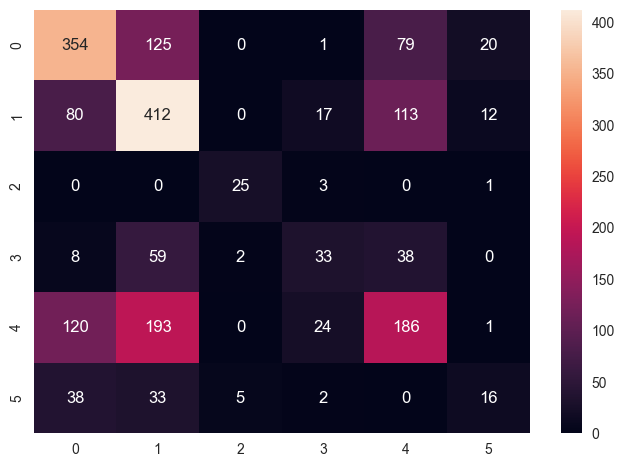

In [92]:
xgb = XGBClassifier()
xgb.fit(usage_train, labels_attitude_train)

# Predict
preds = xgb.predict(usage_test)

# Accuracy
accuracy = accuracy_score(labels_attitude_test, preds)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
cm = confusion_matrix(labels_attitude_test, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

Le modèle ne performe pas très bien. Il arrive à prédire le cluster des attitudes des consommateurs avec un score de 51% de précision.
Ceci n'est pas trop mauvais compte tenu du fait que nous avons 6 clusters donc 6 classes. Cependant, les résultats ne sont pas assez forts pour être utilisés dans un contexte professionnel.

L'une des possibles explications pour ce résultat est qu'il est difficile de prédire le groupe d'attitudes d'un consommateur en fonction de ses usages. En effet, les usages sont des actions concrètes et mesurables, alors que les attitudes sont des états d'esprit et des opinions qui sont plus difficiles à mesurer.

### Estimation du cluster dans les usages, en fonction des attitudes d'un consommateur

Accuracy: 0.86


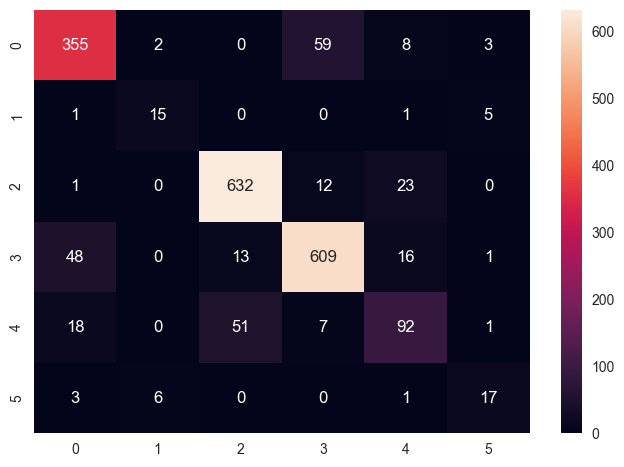

In [93]:
xgb = XGBClassifier()
xgb.fit(attitudes_train, labels_usage_train)

# Predict
preds = xgb.predict(attitudes_test)

# Accuracy
accuracy = accuracy_score(labels_usage_test, preds)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
cm = confusion_matrix(labels_usage_test, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

Ici, le modèle performe très bien. Il arrive à prédire le cluster des usages des consommateurs avec un score de 86% de précision.
Ceci est un résultat très satisfaisant et montre que les attitudes des consommateurs sont un bon indicateur des usages de leur jardin.
De plus, ce résultat est cohérent avec les résultats de la partie 2.2, où nous avons vu que les usages sont mieux représentés par notre modèle que les attitudes.

# Conclusion

Nous avons réussi à clusteriser les consommateurs en fonction de leurs attitudes et de leurs usages. Nous avons choisi de retenir 6 clusters pour notre analyse. Les clusters formés par KMeans semblent les plus qualitatifs de tous les algorihmes pour les attitudes et les clusters formés par Agglomerative filtering semblent les plus qualitatifs de tous les algorihmes pour les usages.

Nous avons également réussi à déterminer le nombre de variables à retenir pour chaque groupe. Pour les attitudes, nous pourrions réduire le nombre de questions à 10 (les 10 questions les plus importantes pour notre modèle) tout en gardant une 80% de précision. Pour les usages, nous pourrions réduire le nombre de questions à 5 (les 5 questions les plus importantes pour notre modèle) tout en gardant une précision de 75%.

Enfin, nous avons réussi à prédire le cluster d'un groupe de variables en fonction des clusters de l'autre groupe de variables. Nous avons vu que les attitudes des consommateurs sont un bon indicateur des usages de leur jardin.